In [1]:
#Load libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import numpy as np
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
plt.style.use('ggplot')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load training datasets
train = pd.read_csv('train.csv')
# Load test dataset
test = pd.read_csv('test.csv')
sample_subm = pd.read_csv('sample_submission2.csv')

In [3]:
# Inspect train Data
train.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


In [4]:
train.shape

(38312, 19)

In [5]:
test.shape

(16496, 18)

In [6]:
print(train.describe())

       Trainings_Attended  Year_of_birth  Last_performance_score  \
count        38312.000000   38312.000000            38312.000000   
mean             2.253680    1986.209334                7.698959   
std              0.609443       7.646047                3.744135   
min              2.000000    1950.000000                0.000000   
25%              2.000000    1982.000000                5.000000   
50%              2.000000    1988.000000                7.500000   
75%              2.000000    1992.000000               10.000000   
max             11.000000    2001.000000               12.500000   

       Year_of_recruitment   Targets_met  Previous_Award  \
count         38312.000000  38312.000000    38312.000000   
mean           2013.139695      0.352996        0.023152   
std               4.261451      0.477908        0.150388   
min            1982.000000      0.000000        0.000000   
25%            2012.000000      0.000000        0.000000   
50%            2014.000000 

In [7]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38312 entries, 0 to 38311
Data columns (total 19 columns):
EmployeeNo                             38312 non-null object
Division                               38312 non-null object
Qualification                          36633 non-null object
Gender                                 38312 non-null object
Channel_of_Recruitment                 38312 non-null object
Trainings_Attended                     38312 non-null int64
Year_of_birth                          38312 non-null int64
Last_performance_score                 38312 non-null float64
Year_of_recruitment                    38312 non-null int64
Targets_met                            38312 non-null int64
Previous_Award                         38312 non-null int64
Training_score_average                 38312 non-null int64
State_Of_Origin                        38312 non-null object
Foreign_schooled                       38312 non-null object
Marital_Status                         383

In [8]:
train.dtypes.value_counts()

object     11
int64       7
float64     1
dtype: int64

In [9]:
test.dtypes.value_counts()

object     11
int64       6
float64     1
dtype: int64

In [10]:
train.duplicated().sum()

0

In [11]:
test.duplicated().sum()

0

In [12]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: EmployeeNo                                0
Division                                  0
Qualification                          1679
Gender                                    0
Channel_of_Recruitment                    0
Trainings_Attended                        0
Year_of_birth                             0
Last_performance_score                    0
Year_of_recruitment                       0
Targets_met                               0
Previous_Award                            0
Training_score_average                    0
State_Of_Origin                           0
Foreign_schooled                          0
Marital_Status                            0
Past_Disciplinary_Action                  0
Previous_IntraDepartmental_Movement       0
No_of_previous_employers                  0
Promoted_or_Not                           0
dtype: int64


In [13]:
# Check for missing values in test data
print('missing values:', test.isnull().sum())

missing values: EmployeeNo                               0
Division                                 0
Qualification                          730
Gender                                   0
Channel_of_Recruitment                   0
Trainings_Attended                       0
Year_of_birth                            0
Last_performance_score                   0
Year_of_recruitment                      0
Targets_met                              0
Previous_Award                           0
Training_score_average                   0
State_Of_Origin                          0
Foreign_schooled                         0
Marital_Status                           0
Past_Disciplinary_Action                 0
Previous_IntraDepartmental_Movement      0
No_of_previous_employers                 0
dtype: int64


There are missing values in the column: 'Qualification'

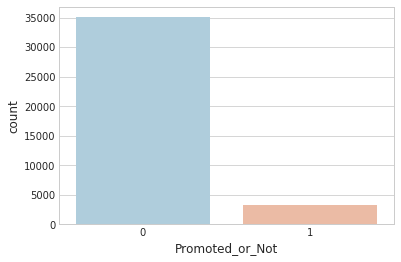

In [14]:
# Target distribution
sns.set_style('whitegrid')
sns.countplot(x = 'Promoted_or_Not',data = train, palette = 'RdBu_r')

In [15]:
Promoted = train.loc[train['Promoted_or_Not'] == 1]
Not_promoted = train.loc[train['Promoted_or_Not'] == 0]
print("We have", len(Promoted), "Promoted data points and", len(Not_promoted), "Not_promoted data points.")

We have 3241 Promoted data points and 35071 Not_promoted data points.


In [16]:
# (3241/38312) * 100  = 8.459490499060347~ 8.5% for promoted data points.

In [17]:
train['Qualification'].value_counts()

First Degree or HND         25578
MSc, MBA and PhD            10469
Non-University Education      586
Name: Qualification, dtype: int64

In [18]:
train = train.replace(np.nan, 'Not_Specified')
test = test.replace(np.nan, 'Not_Specified')

In [19]:
train.isnull().sum()

EmployeeNo                             0
Division                               0
Qualification                          0
Gender                                 0
Channel_of_Recruitment                 0
Trainings_Attended                     0
Year_of_birth                          0
Last_performance_score                 0
Year_of_recruitment                    0
Targets_met                            0
Previous_Award                         0
Training_score_average                 0
State_Of_Origin                        0
Foreign_schooled                       0
Marital_Status                         0
Past_Disciplinary_Action               0
Previous_IntraDepartmental_Movement    0
No_of_previous_employers               0
Promoted_or_Not                        0
dtype: int64

In [20]:
test.isnull().sum()

EmployeeNo                             0
Division                               0
Qualification                          0
Gender                                 0
Channel_of_Recruitment                 0
Trainings_Attended                     0
Year_of_birth                          0
Last_performance_score                 0
Year_of_recruitment                    0
Targets_met                            0
Previous_Award                         0
Training_score_average                 0
State_Of_Origin                        0
Foreign_schooled                       0
Marital_Status                         0
Past_Disciplinary_Action               0
Previous_IntraDepartmental_Movement    0
No_of_previous_employers               0
dtype: int64

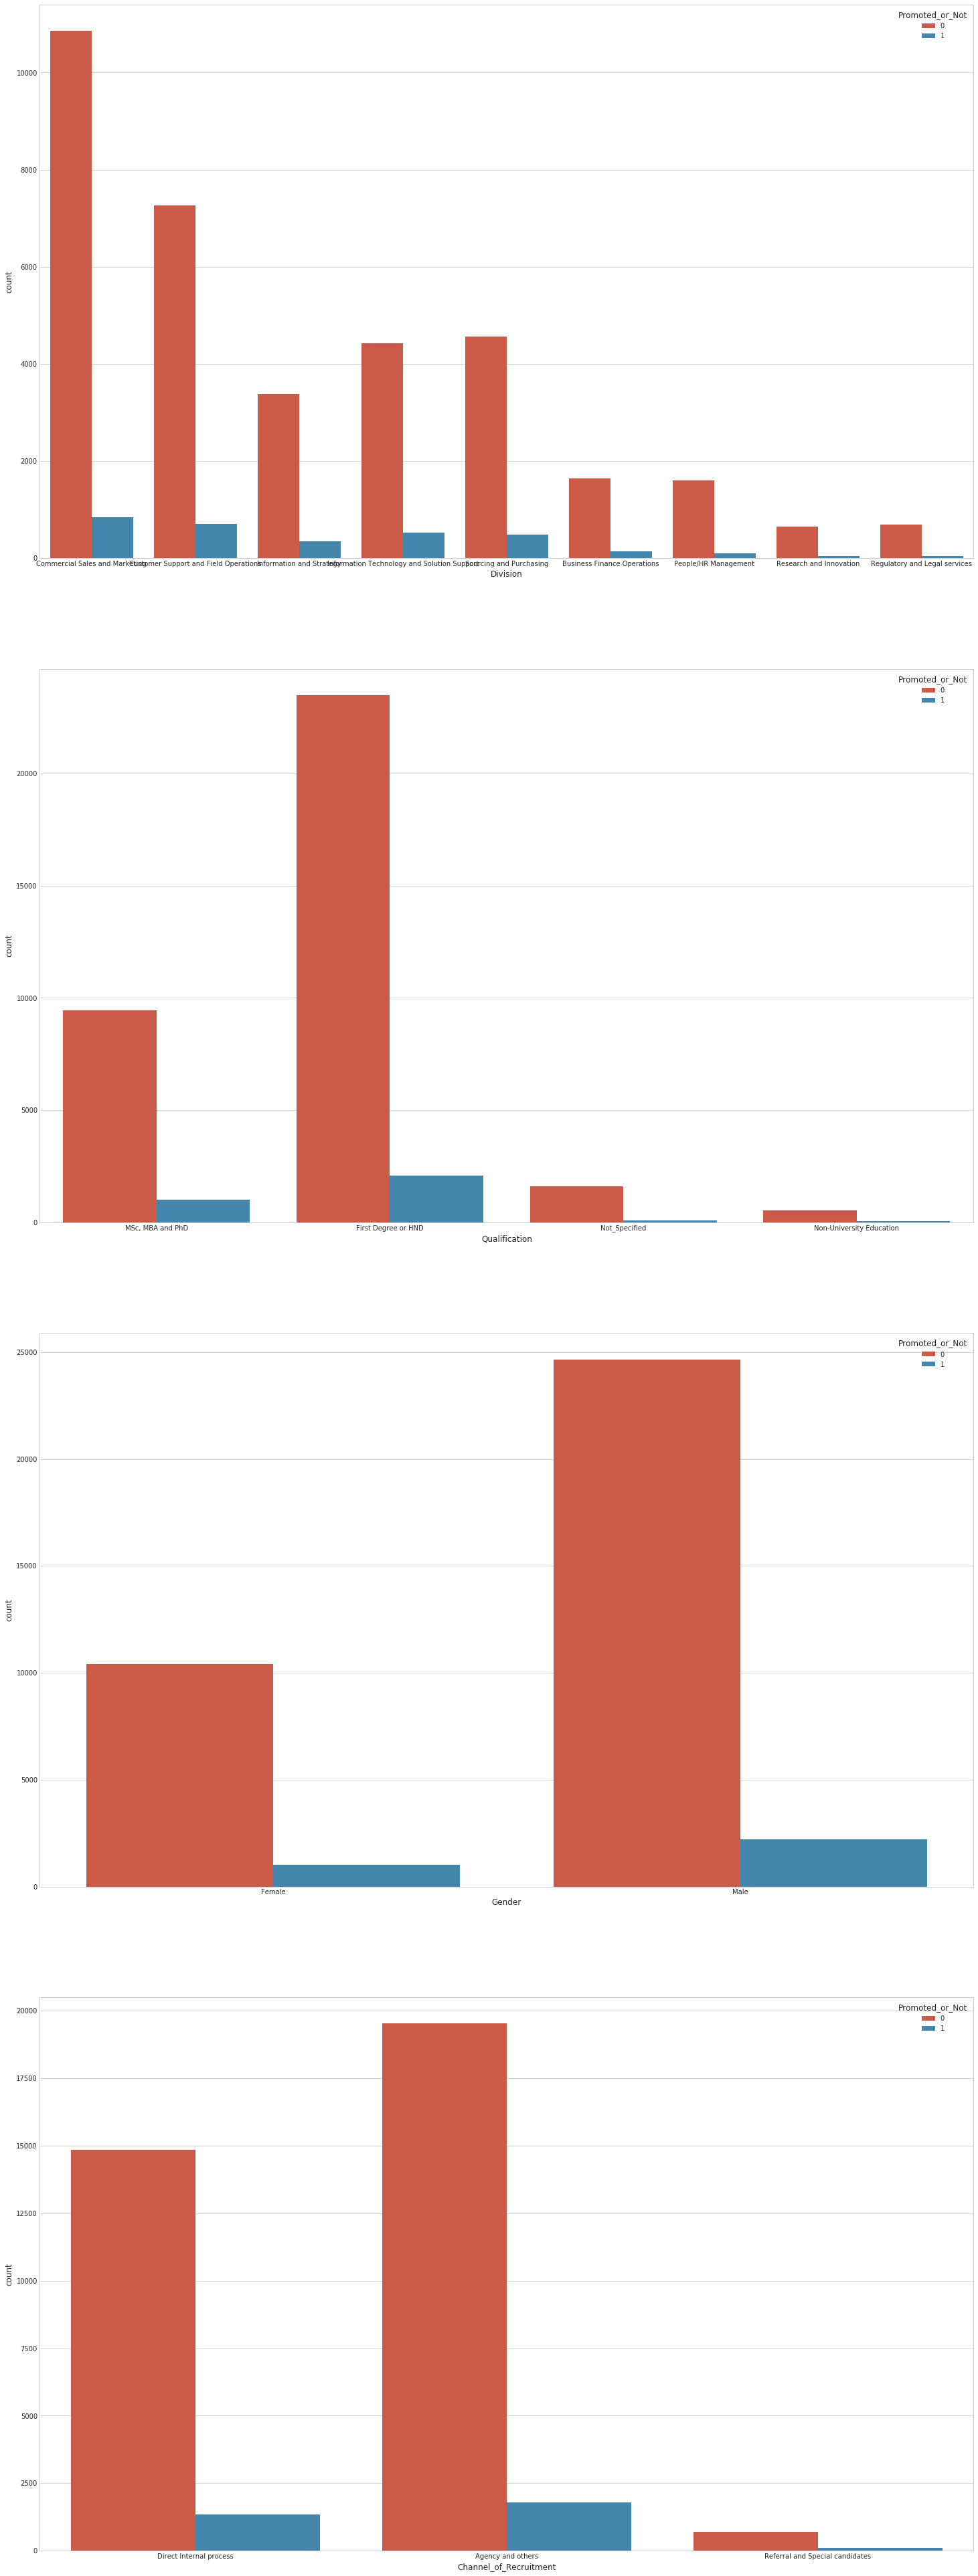

In [21]:
# Data visualisation 
import seaborn as sns

f, axes = plt.subplots(4, 1, figsize=[25, 70])

sns.countplot('Division', hue= 'Promoted_or_Not', data=train, ax=axes[0])
sns.countplot('Qualification', hue= 'Promoted_or_Not', data=train, ax=axes[1])
sns.countplot('Gender', hue= 'Promoted_or_Not', data=train, ax=axes[2])
sns.countplot('Channel_of_Recruitment', hue= 'Promoted_or_Not', data=train, ax=axes[3])


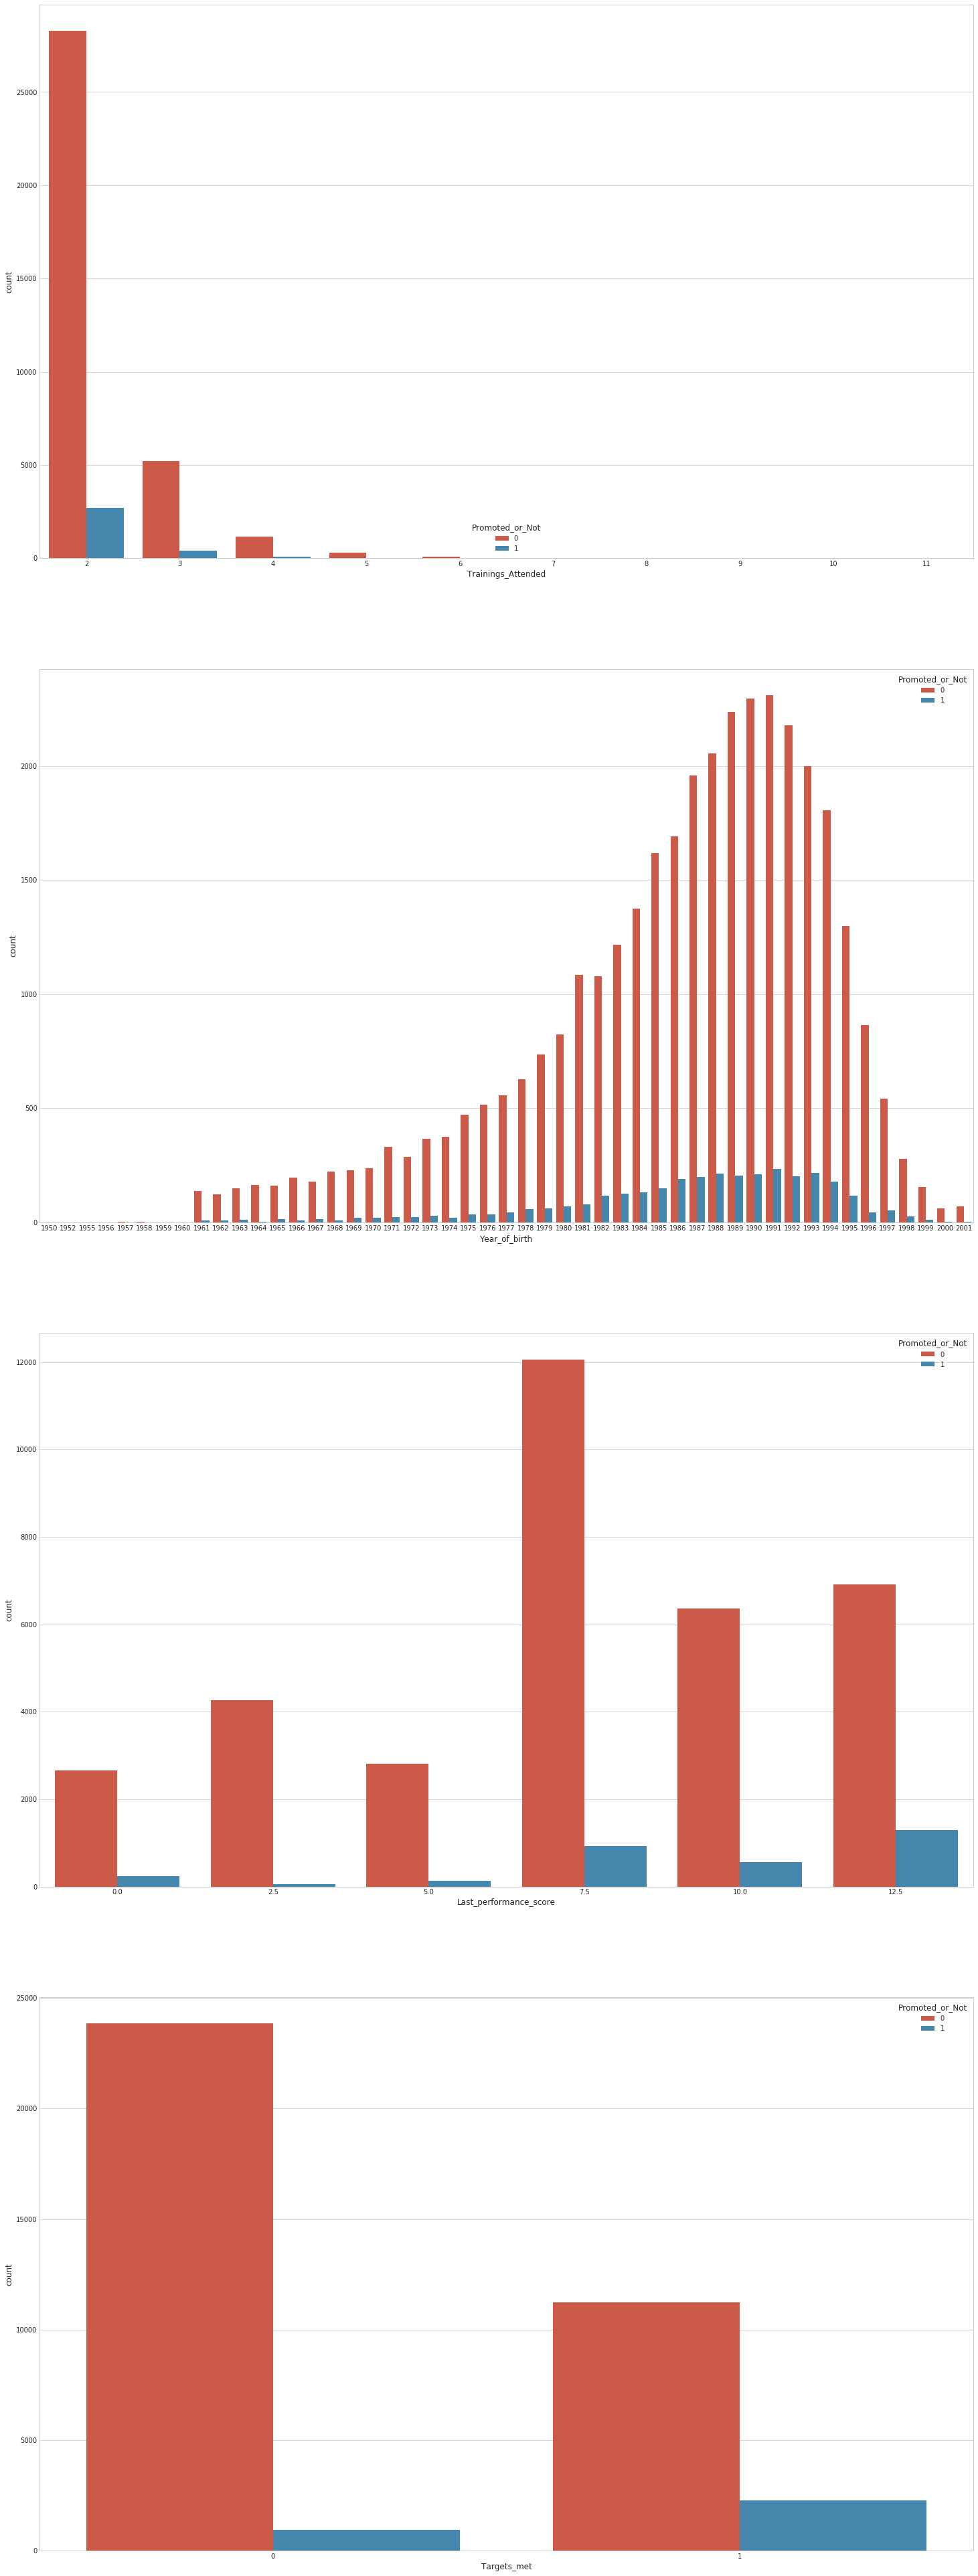

In [22]:
f, axes = plt.subplots(4, 1, figsize=[25, 70])
sns.countplot('Trainings_Attended', hue= 'Promoted_or_Not', data=train, ax=axes[0])
sns.countplot('Year_of_birth', hue= 'Promoted_or_Not', data=train, ax=axes[1])
sns.countplot('Last_performance_score', hue= 'Promoted_or_Not', data=train, ax=axes[2])
sns.countplot('Targets_met', hue= 'Promoted_or_Not', data=train, ax=axes[3])

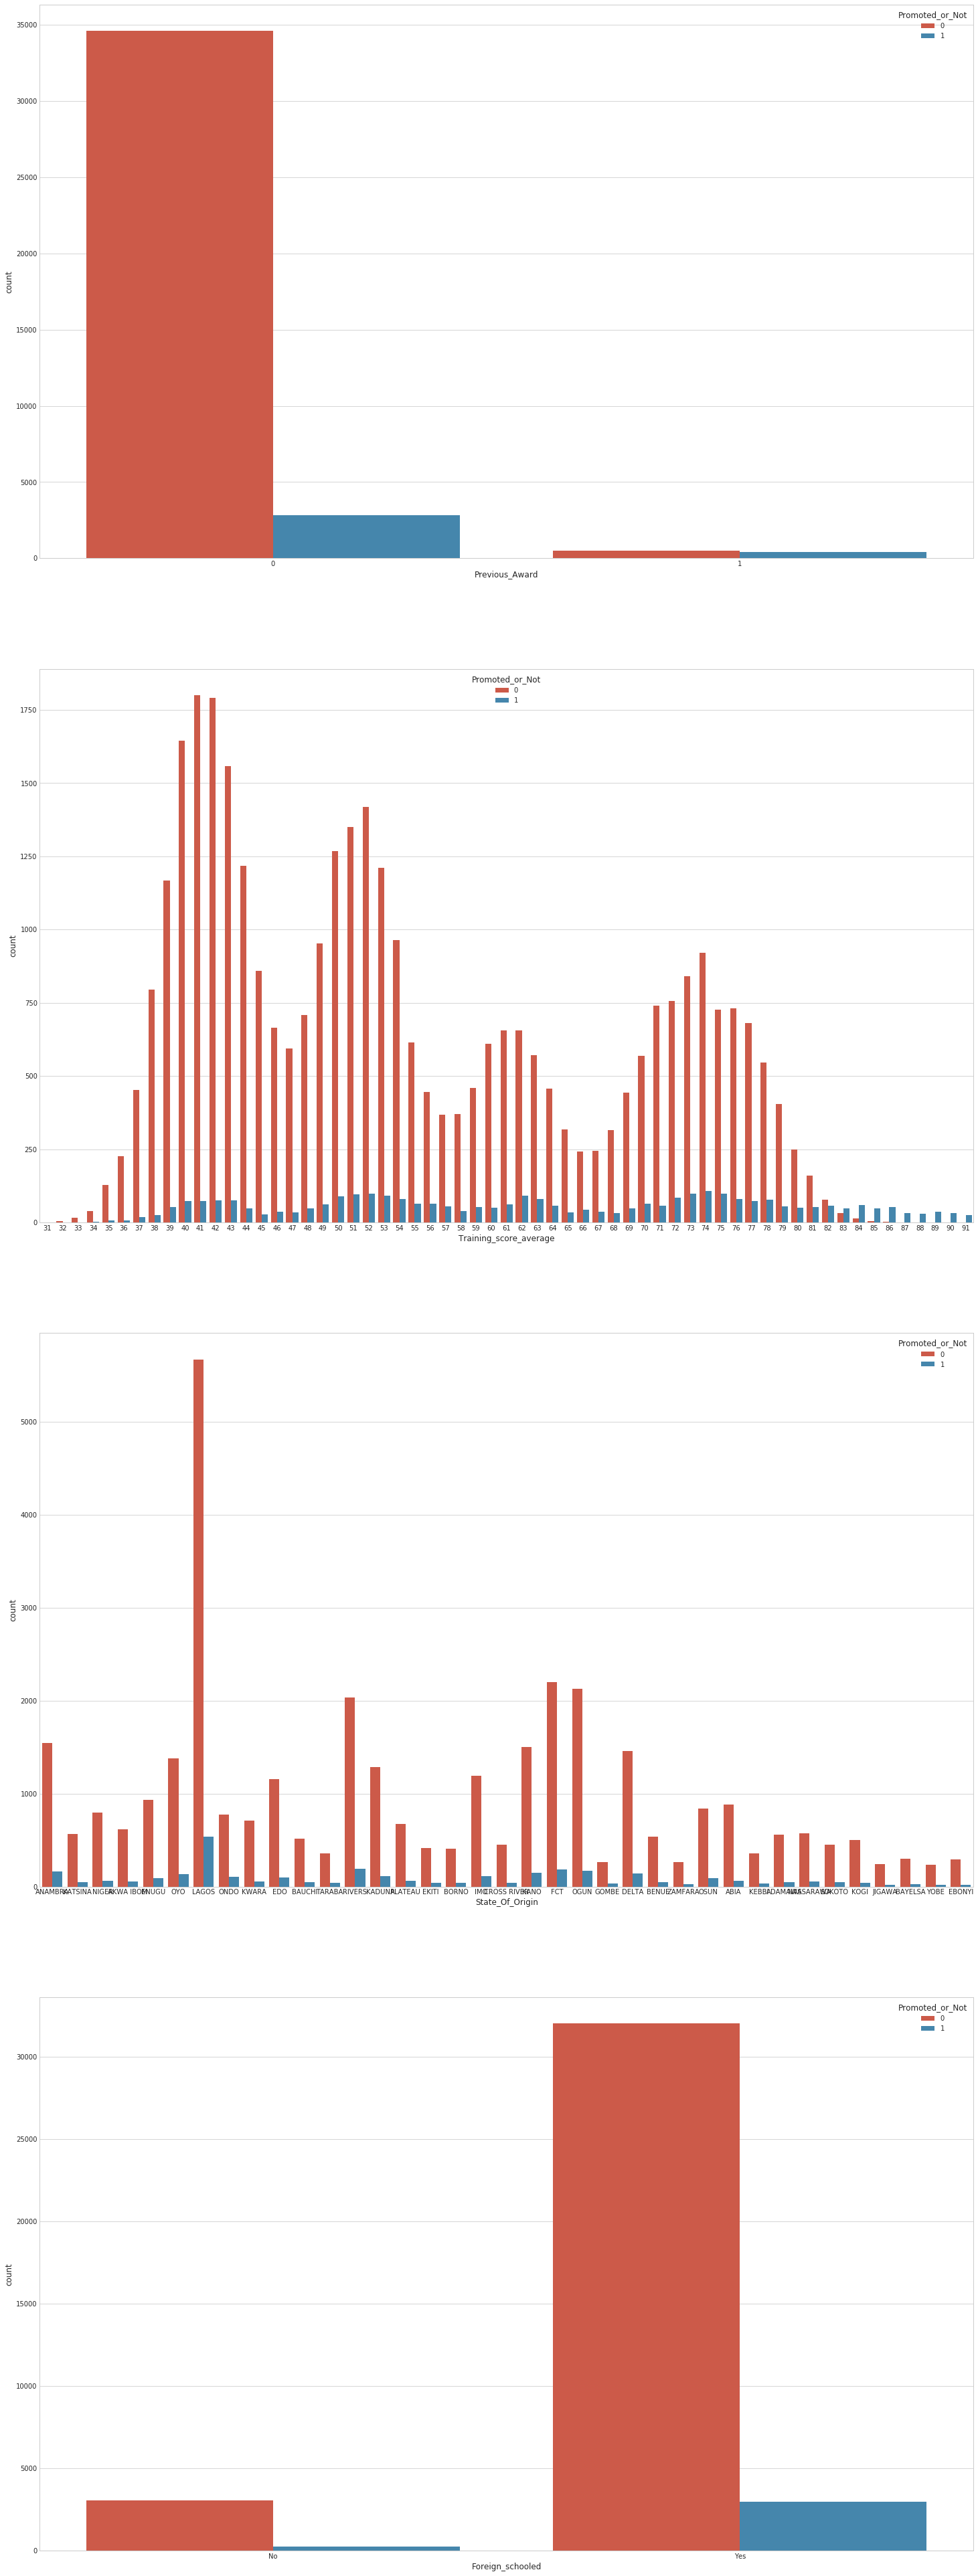

In [23]:
f, axes = plt.subplots(4, 1, figsize=[25, 70])


sns.countplot('Previous_Award', hue= 'Promoted_or_Not', data=train, ax=axes[0])
sns.countplot('Training_score_average', hue= 'Promoted_or_Not', data=train, ax=axes[1])
sns.countplot('State_Of_Origin', hue= 'Promoted_or_Not', data=train, ax=axes[2])
sns.countplot('Foreign_schooled', hue= 'Promoted_or_Not', data=train, ax=axes[3])


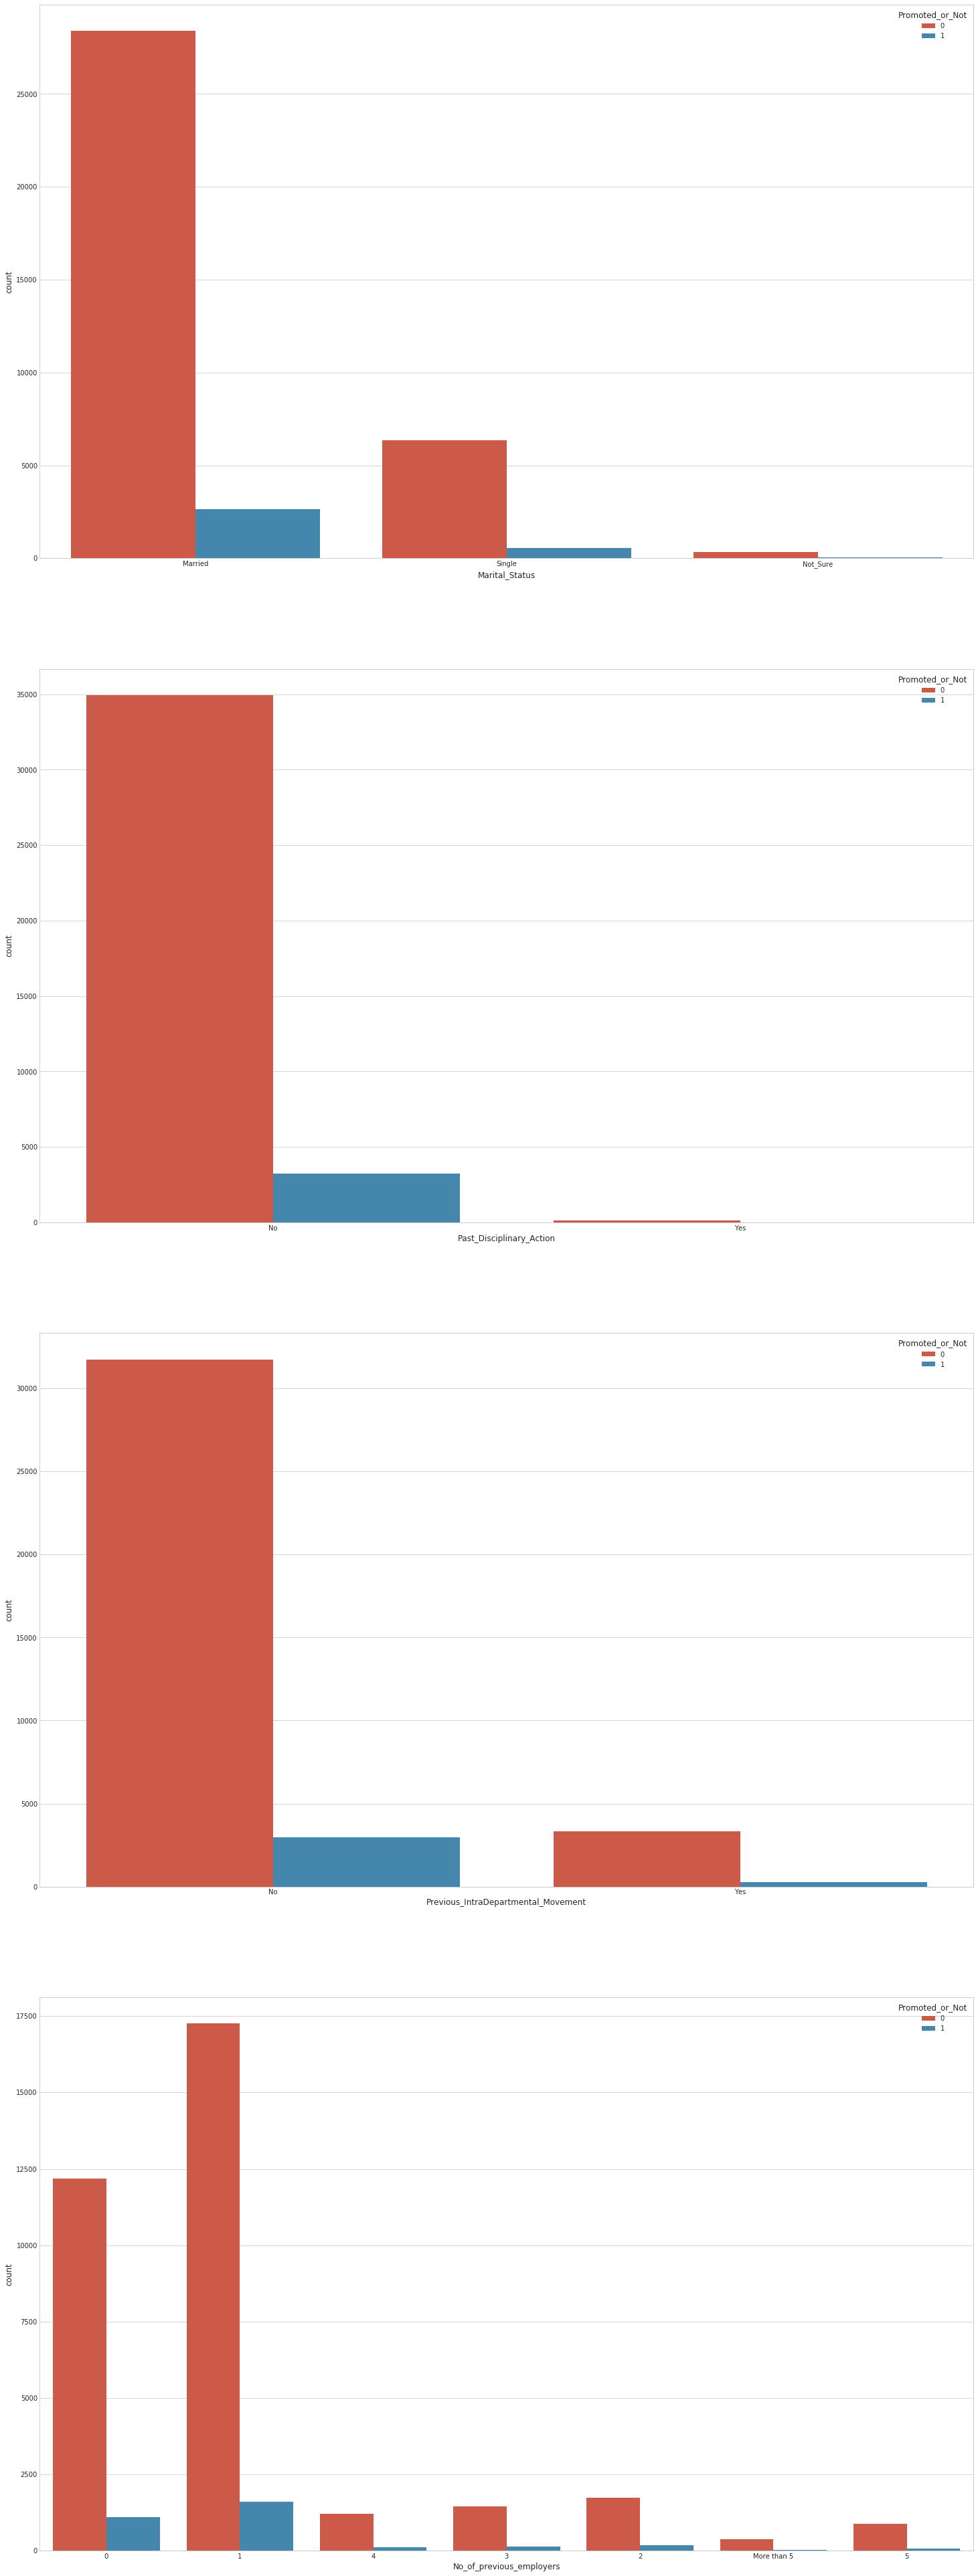

In [24]:
f, axes = plt.subplots(4, 1, figsize=[25, 70])

sns.countplot('Marital_Status', hue= 'Promoted_or_Not', data=train, ax=axes[0])
sns.countplot('Past_Disciplinary_Action', hue= 'Promoted_or_Not', data=train, ax=axes[1])
sns.countplot('Previous_IntraDepartmental_Movement', hue= 'Promoted_or_Not', data=train, ax=axes[2])
sns.countplot('No_of_previous_employers', hue= 'Promoted_or_Not', data=train, ax=axes[3])

In [25]:


# Convert the following numerical labels from integer to float
train[['Trainings_Attended', 'Year_of_recruitment','Targets_met', 'Previous_Award','Training_score_average', 'Year_of_birth']] = train[['Trainings_Attended', 'Year_of_recruitment','Targets_met', 'Previous_Award','Training_score_average', 'Year_of_birth']].values.astype(float)
test[['Trainings_Attended', 'Year_of_recruitment','Targets_met', 'Previous_Award','Training_score_average', 'Year_of_birth']] = test[['Trainings_Attended', 'Year_of_recruitment', 'Targets_met', 'Previous_Award','Training_score_average', 'Year_of_birth']].values.astype(float)

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [27]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38312 entries, 0 to 38311
Data columns (total 19 columns):
EmployeeNo                             38312 non-null object
Division                               38312 non-null object
Qualification                          38312 non-null object
Gender                                 38312 non-null object
Channel_of_Recruitment                 38312 non-null object
Trainings_Attended                     38312 non-null float64
Year_of_birth                          38312 non-null float64
Last_performance_score                 38312 non-null float64
Year_of_recruitment                    38312 non-null float64
Targets_met                            38312 non-null float64
Previous_Award                         38312 non-null float64
Training_score_average                 38312 non-null float64
State_Of_Origin                        38312 non-null object
Foreign_schooled                       38312 non-null object
Marital_Status                

In [28]:
# Data preprocessing 
# convert categorical features to numerical features
# categorical features to be converted by One Hot Encoding


categ = ['Division', 'Qualification', 'Channel_of_Recruitment', 'Marital_Status']
# One Hot Encoding conversion
train = pd.get_dummies(train, prefix_sep='_', columns = categ)

test = pd.get_dummies(test, prefix_sep='_', columns = categ)



In [29]:
# Labelncoder conversion
train['Foreign_schooled'] = le.fit_transform(train['Foreign_schooled'])
train['Past_Disciplinary_Action'] = le.fit_transform(train['Past_Disciplinary_Action'])
train['Previous_IntraDepartmental_Movement'] = le.fit_transform(train['Previous_IntraDepartmental_Movement'])
train['Gender'] = le.fit_transform(train['Gender'])

In [30]:
# Labelncoder conversion
test['Foreign_schooled'] = le.fit_transform(test['Foreign_schooled'])
test['Past_Disciplinary_Action'] = le.fit_transform(test['Past_Disciplinary_Action'])
test['Previous_IntraDepartmental_Movement'] = le.fit_transform(test['Previous_IntraDepartmental_Movement'])
test['Gender'] = le.fit_transform(test['Gender'])

In [31]:
cleanup_nums = {"State_Of_Origin":   {"LAGOS": 1, "FCT": 2, "OGUN": 3, "RIVERS": 4, "ANAMBRA": 5, "KANO" : 6, "DELTA": 7, "OYO" : 8, "KADUNA": 9, "IMO" : 10, "EDO": 11, "ENUGU" : 12, "ABIA" : 13, "OSUN" : 14, "ONDO": 15, "NIGER": 16, "KWARA" : 17, "PLATEAU" : 18, "AKWA IBOM": 19, "NASSARAWA" : 20, "KATSINA" : 21, "ADAMAWA": 22, "BENUE" : 23, "BAUCHI": 24, "KOGI": 25, "SOKOTO": 26, "CROSS RIVER": 27, "EKITI" : 28, "BORNO":29, "TARABA" : 30, "KEBBI" : 31, "BAYELSA" : 32, "EBONYI": 33, "GOMBE": 34, "ZAMFARA" : 35, "JIGAWA": 36, "YOBE": 37  }}

In [32]:
train.replace(cleanup_nums, inplace=True)
test.replace(cleanup_nums, inplace=True)

In [33]:
cleanup_nums1 = {"No_of_previous_employers":   {"More than 5": 6}}

In [34]:
train.replace(cleanup_nums1, inplace=True)
test.replace(cleanup_nums1, inplace=True)
train.head()

,EmployeeNo,Gender,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,...,Qualification_First Degree or HND,"Qualification_MSc, MBA and PhD",Qualification_Non-University Education,Qualification_Not_Specified,Channel_of_Recruitment_Agency and others,Channel_of_Recruitment_Direct Internal process,Channel_of_Recruitment_Referral and Special candidates,Marital_Status_Married,Marital_Status_Not_Sure,Marital_Status_Single
0,YAK/S/00001,0,2.0,1986.0,12.5,2011.0,1.0,0.0,41.0,5,...,0,1,0,0,0,1,0,1,0,0
1,YAK/S/00002,1,2.0,1991.0,12.5,2015.0,0.0,0.0,52.0,5,...,1,0,0,0,1,0,0,1,0,0
2,YAK/S/00003,1,2.0,1987.0,7.5,2012.0,0.0,0.0,42.0,21,...,1,0,0,0,0,1,0,1,0,0
3,YAK/S/00004,1,3.0,1982.0,2.5,2009.0,0.0,0.0,42.0,16,...,1,0,0,0,1,0,0,0,0,1
4,YAK/S/00006,1,3.0,1990.0,7.5,2012.0,0.0,0.0,77.0,19,...,1,0,0,0,0,1,0,1,0,0


In [35]:
test.head()

,EmployeeNo,Gender,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,...,Qualification_First Degree or HND,"Qualification_MSc, MBA and PhD",Qualification_Non-University Education,Qualification_Not_Specified,Channel_of_Recruitment_Agency and others,Channel_of_Recruitment_Direct Internal process,Channel_of_Recruitment_Referral and Special candidates,Marital_Status_Married,Marital_Status_Not_Sure,Marital_Status_Single
0,YAK/S/00005,1,2.0,1976.0,7.5,2017.0,0.0,0.0,65.0,2,...,1,0,0,0,1,0,0,1,0,0
1,YAK/S/00011,1,2.0,1991.0,0.0,2018.0,0.0,0.0,69.0,3,...,0,0,0,1,0,1,0,1,0,0
2,YAK/S/00015,1,2.0,1984.0,7.5,2012.0,0.0,0.0,76.0,6,...,0,1,0,0,0,1,0,1,0,0
3,YAK/S/00016,1,2.0,1984.0,2.5,2009.0,0.0,0.0,52.0,4,...,1,0,0,0,1,0,0,0,0,1
4,YAK/S/00017,1,2.0,1983.0,7.5,2014.0,1.0,0.0,69.0,2,...,1,0,0,0,1,0,0,1,0,0


In [36]:
train[ 'No_of_previous_employers'] = train[ 'No_of_previous_employers'].values.astype(float)

In [37]:
#Separate training features from target
X_train = train.drop(['EmployeeNo', 'Promoted_or_Not'], axis=1)
y_train = train['Promoted_or_Not']

X_test = test.drop([ 'EmployeeNo'], axis=1)

In [38]:
#rescale X_train and X_test
# import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.fit_transform(X_test)

In [39]:
X_train_rescaled.shape

(38312, 32)

In [40]:
# Split train_data
from sklearn.model_selection import train_test_split

X_Train, X_val, y_Train, y_val = train_test_split(X_train_rescaled, y_train, stratify = y_train, test_size = 0.20, random_state=42)

In [41]:
#import XGBClassifier
from xgboost import XGBClassifier

my_model = XGBClassifier()


In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score

# fit and Evaluate model
my_model3 = XGBClassifier(silent=False, n_estimators=100,learning_rate= 0.1, objective='binary:logistic', min_child_weight = 4, gamma = 5, scale_pos_weight= 3, subsample = 1, colsample_bytree = 0.8, max_depth = 6)
my_model3.fit(X_Train, y_Train)
y_pred = my_model3.predict(X_val)

# Get f1 score
print("ROC_AUC Score of Xgboost classifier: ", roc_auc_score(y_val, y_pred))

# Get confusion matrix
confusion_matrix(y_pred, y_val)

ROC_AUC Score of Xgboost classifier:  0.7088256645811885


array([[6892,  366],
       [ 123,  282]])

In [43]:
print("Accuracy Score of Xgboost classifier: ", accuracy_score(y_val, y_pred))

Accuracy Score of Xgboost classifier:  0.9361868719822524


In [44]:
# Get the predicted result for the test Data
test.Promoted_or_Not = my_model3.predict(X_test_rescaled)

In [45]:
# create submission DataFrame
submission_df3 = pd.DataFrame({"EmployeeNo": test["EmployeeNo"],'Promoted_or_Not': test.Promoted_or_Not})

In [46]:
submission_df3.head()

,EmployeeNo,Promoted_or_Not
0,YAK/S/00005,0
1,YAK/S/00011,0
2,YAK/S/00015,0
3,YAK/S/00016,0
4,YAK/S/00017,0


In [47]:
# Create submission csv file
submission_df3.to_csv('SubmisionFile.csv', index = False)

### Balanced Random Forest Classifier

In [48]:
brf = BalancedRandomForestClassifier(n_estimators=1000)
brf.fit(X_Train, y_Train) 

pred = brf.predict(X_val)
print(roc_auc_score(y_val,pred))


0.8018828700403897


In [50]:
print(accuracy_score(y_val,pred))

0.7065118099960851


Data source: https://www.kaggle.com/c/intercampusai2019/leaderboard